In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


from IPython.display import Image
from torchvision.transforms import ToPILImage
from einops import rearrange, reduce, repeat

import matplotlib.pyplot as plt


from torchvision.transforms import RandomPerspective

import nvdiffrast.torch as dr


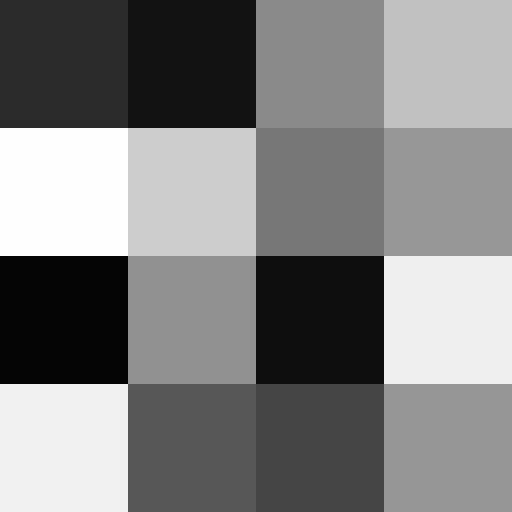

In [11]:

to_img = ToPILImage()

# Make test noise

test_noise = torch.randn(1,1,4,4)

# Just for visualization

view_test_noise = F.interpolate(test_noise, scale_factor=(128,128), mode='nearest')
to_img(view_test_noise[0])

# test_noise


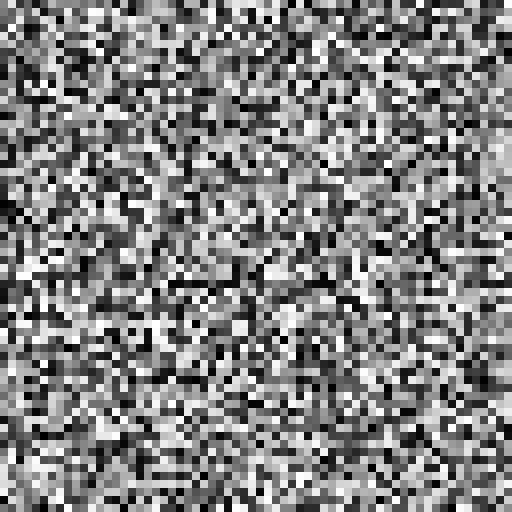

In [12]:

def cond_noise_sampling(src_noise, level=4):
    
    B, C, H, W = src_noise.shape
    
    up_factor = 2 ** level
    
    upscaled_means = F.interpolate(src_noise, scale_factor=(up_factor, up_factor), mode='nearest')
    
    up_H = up_factor * H
    up_W = up_factor * W
    
    """
        1) Unconditionally sample a discrete Nk x Nk Gaussian sample
    """
    
    raw_rand = torch.randn(B, C, up_H, up_W)
    
    """
        2) Remove its mean from it
    """
    
    squared_rand = rearrange(raw_rand, 'b c (h1 h2) (w1 w2) -> b c (h1 w1) (h2 w2)', h2=up_factor, w2=up_factor)
    squared_means = torch.mean(squared_rand, dim=-1)[...,None].repeat(1,1,1,up_factor * up_factor)
    resized_means = rearrange(squared_means, 'b c (h1 w1) (h2 w2) -> b c (h1 h2) (w1 w2)', h2=up_factor, w1 = W)
    
    mean_removed_rand = raw_rand - resized_means
    
    """
        3) Add the pixel value to it
    """

    up_noise = upscaled_means / up_factor + mean_removed_rand
    
    return up_noise


up_noise = cond_noise_sampling(test_noise, level=4)

up_noise_vis = F.interpolate(up_noise, size=(512,512), mode='nearest')

to_img(up_noise_vis[0])


In [13]:

# def noise_warping(src_noise, tgt_to_src_map):
    
    # Target to Source Mapping will have twice the resolution
    
src_noise = test_noise

num_orig_pix = 64

B, C, H, W = src_noise.shape

## Making Pseudo-Warped Coords

warp_i, warp_j = torch.meshgrid(
        torch.arange(W *2 + 1),
        torch.arange(H *2 + 1),
        indexing="ij",
    )

warp_idxs =  (torch.stack((warp_i, warp_j), dim=-1) - torch.tensor([4,4])[None,None,...]) / 1.4

deg = torch.tensor([0.5])

rotmat = torch.tensor([[torch.cos(deg), -torch.sin(deg)], [torch.sin(deg), torch.cos(deg)]])

tgt_to_src_map = (rotmat[None,None,...] @ warp_idxs[...,None]).squeeze() * 1.0 + torch.tensor([4,4])[None,None,...]


#  + torch.tensor([4,4])[None,None,...]

i, j = torch.meshgrid(
        torch.arange(W, dtype=torch.int8),
        torch.arange(H, dtype=torch.int8),
        indexing="ij",
    )

mesh_idxs = torch.stack((i,j), dim=-1)[...,None,None,:] * 2

per_tri_idxs = torch.tensor([
                [[0,0],[0,1],[1,1]], [[0,0],[1,0],[1,1]], 
                [[0,1],[0,2],[1,2]], [[0,1],[1,1],[1,2]],
                [[1,0],[1,1],[2,1]], [[1,0],[2,0],[2,1]],
                [[1,1],[1,2],[2,2]], [[1,1],[2,1],[2,2]]])[None,None,...]

all_tri_idxs = mesh_idxs + per_tri_idxs

# 2H + 1 인 raysampler 따로 뽑아야 함.... 아니면 그냥 가즈아ㅏㅏㅏㅏㅏ

all_tri_idxs.shape

# print(tgt_to_src_map.shape)

torch.Size([4, 4, 8, 3, 2])

In [14]:

idx_y = all_tri_idxs.reshape(-1,2)[:,0]
idx_x = all_tri_idxs.reshape(-1,2)[:,1]

warped_coords = tgt_to_src_map[idx_y, idx_x].reshape(4 * 4 * 8, 3, 2)

warped_coords.shape


torch.Size([128, 3, 2])

torch.Size([128, 2, 4])


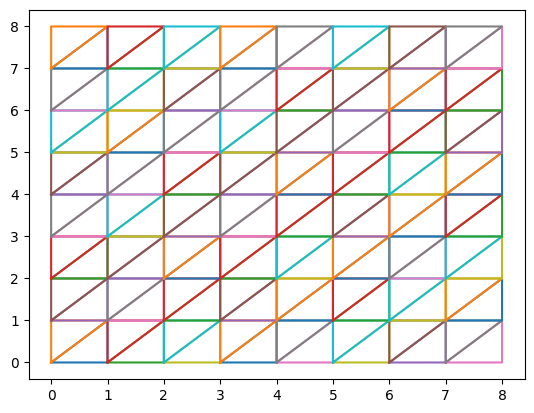

In [15]:
# Visualization

vis_tri_idx = all_tri_idxs.permute(0,1,2,4,3)

vis_tri_idx = vis_tri_idx.reshape(-1,2,3)

# vis_tri_idx = warped_coords


vis_tri_idx = torch.cat((vis_tri_idx, vis_tri_idx[:,:,:1]), dim=-1)

print(vis_tri_idx.shape)

vis_tri_id = torch.flip(vis_tri_idx, dims=[1])

# vis_tri_id[0,0]

for i in vis_tri_id:
    plt.plot(i[0], i[1])

plt.show()


torch.Size([128, 2, 3])
torch.Size([128, 2, 4])


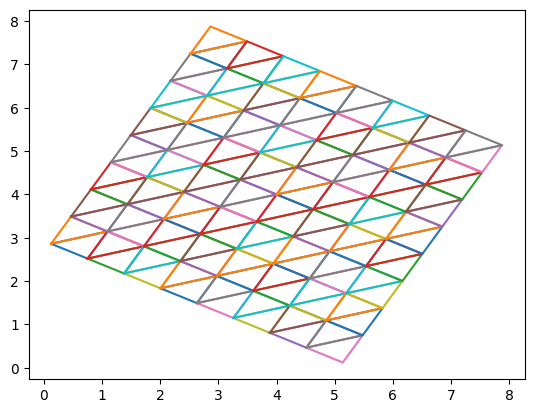

In [16]:
vis_tri_idx = warped_coords.permute(0,2,1)

print(vis_tri_idx.shape)

vis_tri_idx = torch.cat((vis_tri_idx, vis_tri_idx[:,:,:1]), dim=-1)

print(vis_tri_idx.shape)

vis_tri_id = torch.flip(vis_tri_idx, dims=[1])

# vis_tri_id[0,0]

for i in vis_tri_id:
    plt.plot(i[0], i[1])

plt.show()

torch.Size([128, 2, 4])
tensor([[  0,   1,   2],
        [  3,   4,   5],
        [  6,   7,   8],
        [  9,  10,  11],
        [ 12,  13,  14],
        [ 15,  16,  17],
        [ 18,  19,  20],
        [ 21,  22,  23],
        [ 24,  25,  26],
        [ 27,  28,  29],
        [ 30,  31,  32],
        [ 33,  34,  35],
        [ 36,  37,  38],
        [ 39,  40,  41],
        [ 42,  43,  44],
        [ 45,  46,  47],
        [ 48,  49,  50],
        [ 51,  52,  53],
        [ 54,  55,  56],
        [ 57,  58,  59],
        [ 60,  61,  62],
        [ 63,  64,  65],
        [ 66,  67,  68],
        [ 69,  70,  71],
        [ 72,  73,  74],
        [ 75,  76,  77],
        [ 78,  79,  80],
        [ 81,  82,  83],
        [ 84,  85,  86],
        [ 87,  88,  89],
        [ 90,  91,  92],
        [ 93,  94,  95],
        [ 96,  97,  98],
        [ 99, 100, 101],
        [102, 103, 104],
        [105, 106, 107],
        [108, 109, 110],
        [111, 112, 113],
        [114, 115, 116],
 

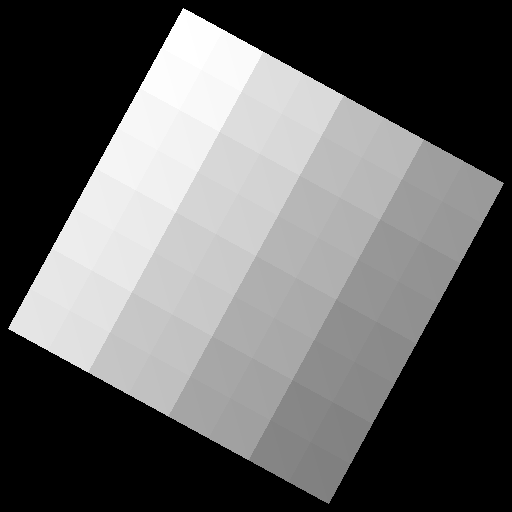

In [19]:
print(vis_tri_idx.shape)

resolution=512

device = "cuda"

vtx_pos =torch.cat(((vis_tri_idx[:,:,:3].permute(0,2,1) - 4 ) / 4, torch.zeros(vis_tri_idx.shape[0], 3, 1), torch.ones(vis_tri_idx.shape[0], 3, 1)), dim=-1)

reshaped_pos = vtx_pos.reshape(-1,4).to(device)
pos_idx = torch.linspace(0, reshaped_pos.shape[0]-1, reshaped_pos.shape[0]).int().reshape(-1,3).to(device)

print(pos_idx)

reshaped_pos = reshaped_pos[None,...]
print(reshaped_pos)

use_opengl = False
glctx = dr.RasterizeGLContext() if use_opengl else dr.RasterizeCudaContext()
print(reshaped_pos.shape)

with torch.no_grad():
    rast_out, rast_out_db = dr.rasterize(glctx, reshaped_pos, pos_idx, resolution=[resolution, resolution])
# Visualization

rast = rast_out[:,:,:,3:].permute(0,3,1,2) 

up_noise_vis = F.interpolate(rast, size=(512,512), mode='nearest')

print(torch.max(rast))

print(up_noise_vis.shape)

print(rast.shape)


rast


to_img(up_noise_vis[0])


